In [10]:
#LOADING THE REQUIERED LIBRARIES
import pandas as pd
import numpy as np
import time
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')
import re
import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from gensim.models import Word2Vec
from lightgbm import LGBMRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# LOADING THE TRAIN DATA
df =  pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cs1/train_processed.csv",index_col=["train_id"])
df

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,name_processed,brand_name_processed,category_name_preprocessed,Tier_1,Tier_2,Tier_3,processed_item_description
train_id,,,,,,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,mlb cincinnati reds shirt size xl,mlb,men/top/tshirts,men,top,tshirts,description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,razer blackwidow chroma keyboard,razer,electronic/computer tablet/component parts,electronic,computer tablet,component parts,keyboard great condition works like came box p...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,avaviv blouse,target,women/top blouse/blouse,women,top blouse,blouse,adorable top hint lace key hole back pale pink...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,leather horse statues,missing,home/home dcor/home dcor accents,home,home dcor,home dcor accents,new tags leather horses retail stand foot high...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,24k gold plated rose,missing,women/jewelry/necklaces,women,jewelry,necklaces,complete certificate authenticity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl...",3.044522,free people inspired dress,free people,women/dresse/midcalf,women,dresse,midcalf,lace says size small fits medium perfectly nev...
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t,2.708050,little mermaid handmade dress,disney,kid/girl 2t5t/dresses,kid,girl 2t5t,dresses,little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape.",2.564949,21 day fix containers eating plan,missing,sport outdoor/exercise/fitnes accessories,sport outdoor,exercise,fitnes accessories,used twice still great shape


In [3]:
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cs1/test_processed.csv",index_col=["test_id"])
df_test

,name,item_condition_id,category_name,brand_name,shipping,item_description,name_processed,brand_name_processed,category_name_preprocessed,Tier_1,Tier_2,Tier_3,processed_item_description
test_id,,,,,,,,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,breast cancer fight like girl ring,ring,women/jewelry/rings,women,jewelry,rings,size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",25 pcs new 75x12 kraft bubble mailers,missing,other/office supplie/shipping supplies,other,office supplie,shipping supplies,25 pcs new 75x12 kraft bubble mailers lined bu...
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,coach bag,coach,vintage collectible/bag and purse/handbag,vintage collectible,bag and purse,handbag,brand new coach bag bought coach outlet
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,floral kimono,missing,women/sweater/cardigan,women,sweater,cardigan,floral kimono never worn lightweight perfect h...
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,life death,missing,other/book/religion spirituality,other,book,religion spirituality,rediscovering life loss loved one tony cooke p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3460720,DARK SAMPLE BYE FOUNDATION MOISTURIZER,1,Beauty/Fragrance/Women,NaN,1,It cosmetics Bye Bye Foundation Full Coverage ...,dark sample bye foundation moisturizer,missing,beauty/fragrance/women,beauty,fragrance,women,cosmetics bye bye foundation full coverage moi...
3460721,bundle for @brandystash,2,Women/Pants/Other,NaN,1,♡2 pairs of omighty trackiez. one m and one s....,bundle brandystash,missing,women/pant/other,women,pant,other,2 pairs omighty trackiez one one prettiest pinks
3460722,Toddler High-top Converse,3,Kids/Girls 0-24 Mos/Shoes,Nike,0,Size 5 (toddler). Pink high top converse shoes...,toddler hightop converse,nike,kid/girl 024 mo/shoes,kid,girl 024 mo,shoes,size 5 toddler pink high top converse shoes st...


## splitting

In [4]:
df_train,df_val = train_test_split(df,test_size=0.1,random_state = 3) 

In [5]:
df_train.shape

(1334281, 15)

In [6]:
df_val.shape

(148254, 15)

In [7]:
df_test.shape

(3460725, 13)

In [9]:
y_train = df_train.log_price
y_val = df_val.log_price

## A.  Benchmark Model

In [ ]:
def benchmark(x_input):
    shipping = [0,1]
    item_condition = [1,2,3,4,5]
    model = dict()
    for i in shipping:
        for j in item_condition:
            model[(i,j)] = df[(df.shipping==i) & (df.item_condition_id==j)]["log_price"].mean()
    
    output = []
    for index,i in x_input.iterrows():
        output.append(model[(i.shipping,i.item_condition_id)])
    return np.array(output)

In [ ]:
train_predict_benchmark = benchmark(df_train)
val_predict_benchmark = benchmark(df_val)


In [ ]:
print("Train Loss Benchmark Model =",np.sqrt(mean_squared_error(y_train,train_predict_benchmark)))

Train Loss Benchmark Model = 0.7267335100295779


In [ ]:
print("Val Loss Benchmark Model =",np.sqrt(mean_squared_error(y_val,val_predict_benchmark)))

Val Loss Benchmark Model = 0.7254971252489131


In [12]:
def log_to_actual(log):
    return np.exp(log)-1

In [ ]:
test_predict_benchmark = benchmark(df_test)
test_predict_benchmark = pd.DataFrame(log_to_actual(test_predict_benchmark),columns=["price"])
test_predict_benchmark.index = df_test.index
test_predict_benchmark

,price
test_id,
0,14.913061
1,14.913061
2,14.913061
3,21.432196
4,15.587577
...,...
3460720,14.913061
3460721,15.814442
3460722,20.377879


In [ ]:
test_predict_benchmark.to_csv("test_predict_benchmark.csv")

### Kaggle Score for Test_data

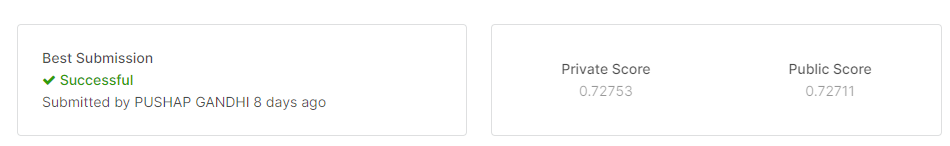

In [9]:
Image("screenshot/benchmark_w2v.png")

# 1. Feature Engineering 
---------------------------------
##    <font color='blue'> **Categorical Data : Label Encoding** </font> 
##   <font color='blue'>**Text Data : Word 2 Vec** </font>

## <font color='green'> Categorical Data  </font> 
## 1. 'brand_name_processed'

In [10]:
label_brand = OrdinalEncoder( handle_unknown='use_encoded_value',unknown_value=-1)
label_brand.fit(df_train.brand_name_processed.values.reshape(-1,1))

train_vec_brand =label_brand.transform(df_train.brand_name_processed.values.reshape(-1,1))
val_vec_brand = label_brand.transform(df_val.brand_name_processed.values.reshape(-1,1))


In [11]:
train_vec_brand.shape

(1334281, 1)

In [12]:
val_vec_brand.shape

(148254, 1)

In [13]:
test_vec_brand = label_brand.transform(df_test.brand_name_processed.values.reshape(-1,1))
test_vec_brand.shape

(3460725, 1)

## 2. 'Tier_1'

In [14]:
label_t1 = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
label_t1.fit(df_train.Tier_1.values.reshape(-1,1))

train_vec_t1 = label_t1.transform(df_train.Tier_1.values.reshape(-1,1))
val_vec_t1 =   label_t1.transform(df_val.Tier_1.values.reshape(-1,1))


In [15]:
train_vec_t1.shape

(1334281, 1)

In [16]:
val_vec_t1.shape

(148254, 1)

In [17]:
test_vec_t1 =   label_t1.transform(df_test.Tier_1.values.reshape(-1,1))
test_vec_t1.shape

(3460725, 1)

## 3. 'Tier_2'

In [18]:
label_t2 = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
label_t2.fit(df_train.Tier_2.values.reshape(-1,1))

train_vec_t2 =label_t2.transform(df_train.Tier_2.values.reshape(-1,1))
val_vec_t2 = label_t2.transform(df_val.Tier_2.values.reshape(-1,1))


In [19]:
train_vec_t2.shape

(1334281, 1)

In [20]:
val_vec_t2.shape

(148254, 1)

In [21]:
test_vec_t2 = label_t2.transform(df_test.Tier_2.values.reshape(-1,1))
test_vec_t2 .shape

(3460725, 1)

## 4. 'Tier_3'

In [22]:
label_t3 = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
label_t3.fit(df_train.Tier_3.values.reshape(-1,1))

train_vec_t3 =label_t3.transform(df_train.Tier_3.values.reshape(-1,1))
val_vec_t3 = label_t3.transform(df_val.Tier_3.values.reshape(-1,1))


In [23]:
train_vec_t3.shape

(1334281, 1)

In [24]:
train_vec_t3.shape

(1334281, 1)

In [21]:
test_vec_t3 = label_t3.transform(df_test.Tier_3.values.reshape(-1,1))
test_vec_t3 .shape

(3460725, 1)

## <font color='green'> Text Data  </font> 
## 5. 'name_processed' + 'item_description'

In [26]:
df_train["concat"] = df_train.name_processed + " "+df_train.processed_item_description
df_val["concat"] = df_val.name_processed + " "+df_val.processed_item_description

In [27]:
df_test["concat"] = df_test.name_processed + " "+df_test.processed_item_description

###  'name_processed' + 'Word2Vec

In [28]:
corpus_name = []
for i in tqdm(df_train.concat):
    corpus_name.append(i.split())

100%|██████████| 1334281/1334281 [00:09<00:00, 138897.64it/s]


In [29]:
name_w2v = Word2Vec(corpus_name,vector_size=300,window= 20)

In [30]:
def sent_to_vec(text):
    vec= np.zeros(shape=(300,),dtype="float32")
    l = len(str(text).split())
    
    for i in str(text).split():
        try:
            vec += name_w2v.wv[i]
        except:
            continue
    if l !=0 :
        avg_vec = vec/l
    return avg_vec

In [ ]:
train_vec_text = np.stack(df_train.concat.apply(sent_to_vec).values)
val_vec_text   = np.stack(df_val.concat.apply(sent_to_vec).values)

In [ ]:
train_vec_text.shape

(1334281, 300)

In [ ]:
val_vec_text.shape

(148254, 300)

In [ ]:
test_vec_text   = np.stack(df_test.concat.apply(sent_to_vec).values)

## 6. 'is_missing'

In [ ]:
df_train["is_missing"]  =  (df_train.brand_name_processed=="missing") | (df_train.name_processed =="missing")| (df_train.processed_item_description=="missing")
df_train["is_missing"]  = df_train["is_missing"].astype(int)

In [ ]:
df_val["is_missing"]  =  (df_val.brand_name_processed=="missing") | (df_val.name_processed =="missing")| (df_val.processed_item_description=="missing")
df_val["is_missing"]  = df_val["is_missing"].astype(int)

In [ ]:
df_test["is_missing"]  =  (df_test.brand_name_processed=="missing") | (df_test.name_processed =="missing")| (df_test.processed_item_description=="missing")
df_test["is_missing"]  = df_test["is_missing"].astype(int)

### Concatenating all Features

In [ ]:
x_train = np.hstack((df_train.item_condition_id.values.reshape(-1,1) , df_train.shipping.values.reshape(-1,1) ,\
                     df_train.is_missing.values.reshape(-1,1) ,
            train_vec_brand , train_vec_t1 , train_vec_t2,train_vec_t3 , train_vec_text))

In [ ]:
x_val = np.hstack((df_val.item_condition_id.values.reshape(-1,1) , df_val.shipping.values.reshape(-1,1),\
                   df_val.is_missing.values.reshape(-1,1),  
                   val_vec_brand,val_vec_t1 , \
                  val_vec_t2,val_vec_t3,val_vec_text))

In [ ]:
x_test = np.hstack((df_test.item_condition_id.values.reshape(-1,1) , df_test.shipping.values.reshape(-1,1),\
                   df_test.is_missing.values.reshape(-1,1),  
                   test_vec_brand,test_vec_t1 , \
                  test_vec_t2,test_vec_t3,
                    test_vec_text))

In [ ]:
x_train.shape

(1334281, 307)

In [ ]:
x_val.shape

(148254, 307)

## Sample Data for Hyperpatameter Tuning

In [ ]:
def sample(x_train,y_train):
    np.random.seed(5)
    index = np.random.random_integers(0,x_train.shape[0]-1,size=int(0.1*x_train.shape[0]))
    
    x_train_s = x_train[index]
    y_train_s = y_train.values[index]
    
    return x_train_s,y_train_s

In [ ]:
x_train_s,y_train_s = sample(x_train,y_train)

In [ ]:
x_train_s.shape

(133428, 307)

In [ ]:
y_train_s.shape

(133428,)

# B. Models
## 1. Lasso

In [ ]:
laso = Lasso()
param =  {"alpha":[10**x for x in range(-5,2)]}
reg_l1 = GridSearchCV(laso,param ,cv=3,verbose=1,return_train_score=True,scoring='neg_root_mean_squared_error',n_jobs=-1)
reg_l1.fit(x_train_s,y_train_s)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


GridSearchCV(cv=3, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

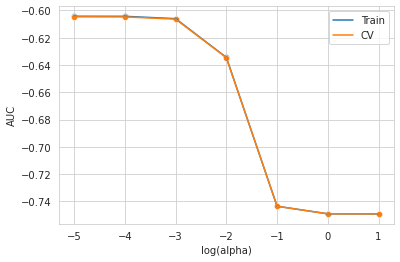

In [ ]:
results = pd.DataFrame(reg_l1.cv_results_)
results = results.sort_values(['param_alpha'])

train_score=results["mean_train_score"] #STORING TRAINING DATASET AUC SCORE
cv_score=results["mean_test_score"] #STORING CV DATESET AUC SCORE
alpha=results["param_alpha"].apply(lambda x:np.log10(x))

sns.set_style("whitegrid")
sns.lineplot(x=alpha,y=train_score,label="Train")
sns.lineplot(x=alpha,y=cv_score,label="CV")
sns.scatterplot(x=alpha,y=train_score)
sns.scatterplot(x=alpha,y=cv_score)
plt.xlabel("log(alpha)")
plt.ylabel("-RMSE")
plt.legend()
plt.show()


In [ ]:
reg_l1.best_params_

{'alpha': 1e-05}

In [ ]:
laso = Lasso(alpha = 10**-5)
laso.fit(x_train,y_train)

Lasso(alpha=1e-05)

In [ ]:
# TRAIN PREDICTION
train_pred_l1 = laso.predict(x_train)
# TEST PREDICTION
val_pred_l1 = laso.predict(x_val)

### Performance

In [ ]:
# TRAIN ERROR
np.sqrt(mean_squared_error(y_train,train_pred_l1))

0.6043821792690721

In [ ]:
# VALIDATION ERROR
np.sqrt(mean_squared_error(y_val , val_pred_l1))

0.6037378604240596

In [ ]:
# TEST PREDICTIONS
laso_predict = pd.DataFrame()
laso_predict["test id"] = df_test.index
laso_predict["price"] = log_to_actual(laso.predict(x_test))
laso_predict.to_csv("laso_predict.csv")
laso_predict

,test id,price
0,0,10.683246
1,1,7.307368
2,2,53.510942
3,3,14.905657
4,4,11.652282
...,...,...
3460720,3460720,10.969647
3460721,3460721,18.968253
3460722,3460722,20.212352
3460723,3460723,17.258540


#### Test Score on kaggle

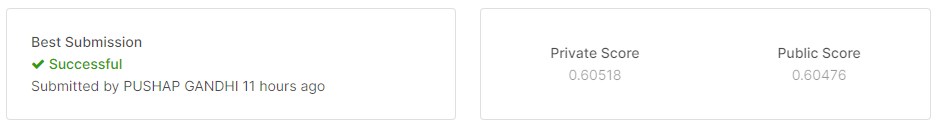

In [11]:
from IPython.display import Image
Image("screenshot/laso_w2v.png") 

## 2. Ridge

In [ ]:
ridge = Ridge()
param =  {"alpha":[10**x for x in range(-5,2)]}
reg_l2 = GridSearchCV(ridge,param ,cv=3,verbose=1,return_train_score=True,scoring='neg_root_mean_squared_error',n_jobs=-1)
reg_l2.fit(x_train_s,y_train_s)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

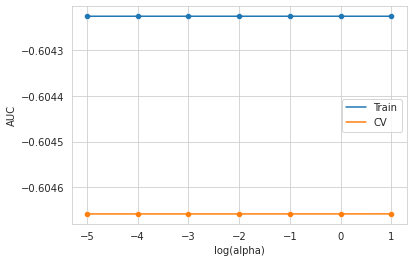

In [ ]:
results = pd.DataFrame(reg_l2.cv_results_)
results = results.sort_values(['param_alpha'])

train_score=results["mean_train_score"] #STORING TRAINING DATASET AUC SCORE
cv_score=results["mean_test_score"] #STORING CV DATESET AUC SCORE
alpha=results["param_alpha"].apply(lambda x:np.log10(x))

sns.set_style("whitegrid")
sns.lineplot(x=alpha,y=train_score,label="Train")
sns.lineplot(x=alpha,y=cv_score,label="CV")
sns.scatterplot(x=alpha,y=train_score)
sns.scatterplot(x=alpha,y=cv_score)
plt.xlabel("log(alpha)")
plt.ylabel("-RMSE")
plt.legend()
plt.show()

In [ ]:
reg_l2.best_params_

{'alpha': 10}

In [ ]:
ridge_best = Ridge(alpha=10)
ridge_best.fit(x_train,y_train)

Ridge(alpha=10)

In [ ]:
train_pred_l2 = ridge_best.predict(x_train)
val_pred_l2 = ridge_best.predict(x_val)

### Performance

In [ ]:
# TRAIN ERROR
np.sqrt(mean_squared_error(y_train , train_pred_l2))

0.6043814535620716

In [ ]:
#VALIDATION ERROR
np.sqrt(mean_squared_error(y_val , val_pred_l2))

0.603741819900018

In [ ]:
# TEST PREDICTION
ridge = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/cs1/actual/ridge","rb"))
ridge_predict = pd.DataFrame()
ridge_predict["test id"] = df_test.index
ridge_predict["price"] = log_to_actual(ridge.predict(x_test))
ridge_predict.to_csv("ridge_predict.csv")
ridge_predict

,test id,price
0,0,10.687584
1,1,7.291336
2,2,53.487361
3,3,14.900464
4,4,11.667400
...,...,...
3460720,3460720,10.943761
3460721,3460721,19.030889
3460722,3460722,20.221429
3460723,3460723,17.267750


### Kaggle Score for test_data

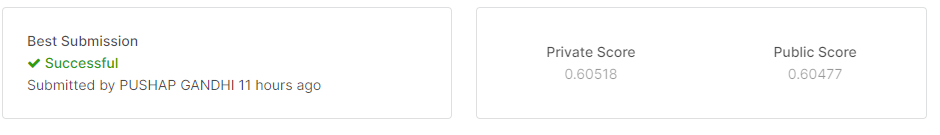

In [5]:
Image("screenshot/ridge_w2v.png")

## 3. DecisionTree

In [ ]:
dt = DecisionTreeRegressor(criterion="mse",max_features="auto")
param =  {"max_depth":[10,50,100,200]}
reg_dt = GridSearchCV(dt,param ,cv=3,verbose=1,return_train_score=True,scoring='neg_root_mean_squared_error',n_jobs=-1)
reg_dt.fit(x_train_s,y_train_s)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(max_features='auto'),
             n_jobs=-1, param_grid={'max_depth': [10, 50, 100, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

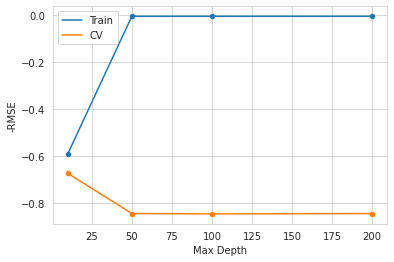

In [ ]:
results = pd.DataFrame(reg_dt.cv_results_)
results = results.sort_values(['param_max_depth'])

train_score=results["mean_train_score"] #STORING TRAINING DATASET AUC SCORE
cv_score=results["mean_test_score"] #STORING CV DATESET AUC SCORE
alpha=results["param_max_depth"]

sns.set_style("whitegrid")
sns.lineplot(x=alpha,y=train_score,label="Train")
sns.lineplot(x=alpha,y=cv_score,label="CV")
sns.scatterplot(x=alpha,y=train_score)
sns.scatterplot(x=alpha,y=cv_score)
plt.xlabel("Max Depth")
plt.ylabel("-RMSE")
plt.legend()
plt.show()

In [ ]:
reg_dt.best_params_

{'max_depth': 10}

In [ ]:
dt_best = DecisionTreeRegressor(criterion="mse",max_depth= 10,max_features="auto")
dt_best.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=10, max_features='auto')

In [ ]:
train_pred_dt = dt_best.predict(x_train)
val_pred_dt = dt_best.predict(x_val)

### Performance

In [ ]:
# TRAIN ERROR
np.sqrt(mean_squared_error(y_train , train_pred_dt))

0.6272699572247143

In [ ]:
# VALIDATION ERROR
np.sqrt(mean_squared_error(y_val , val_pred_dt))

0.6353341034738635

In [ ]:
# TEST PREDICTIONS
dt_predict = pd.DataFrame()
dt_predict["test id"] = df_test.index
dt_predict["price"] = log_to_actual(dt.predict(x_test))
dt_predict.to_csv("dt_predict.csv")
dt_predict

,test id,price
0,0,12.814753
1,1,11.000741
2,2,14.208301
3,3,15.256859
4,4,13.108627
...,...,...
3460720,3460720,13.769152
3460721,3460721,20.424365
3460722,3460722,18.516164
3460723,3460723,20.875658


### Kaggle Score For Test_data

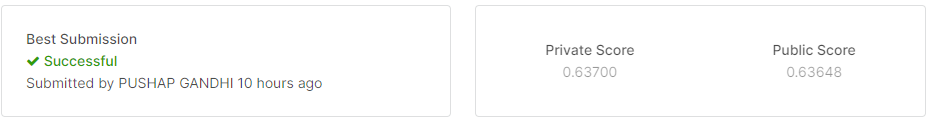

In [7]:
Image("screenshot/dt_w2v.png")

### 4. RandomForest

validation Loss for parameter 10= 0.6139427751510331
validation Loss for parameter 50= 0.5862011431168415
validation Loss for parameter 100= 0.5823190013036049
validation Loss for parameter 200= 0.5797881843743692
validation Loss for parameter 500= 0.5789554399592809


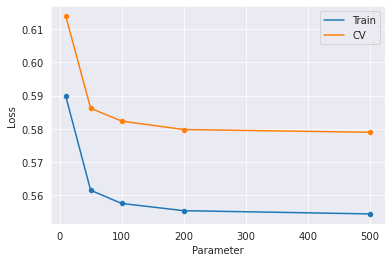

In [ ]:
param =  [10,50,100,200,500]
train_error_list = [] 
val_error_list = []
for i in param:
    rf = RandomForestRegressor( criterion='mse', n_estimators = i , n_jobs=-1)
    rf.fit(x_train_s,y_train_s)
    
    train_pred = rf.predict(x_train)
    val_pred = rf.predict(x_val)
    
    train_error = np.sqrt(mean_squared_error(y_train,train_pred))
    val_error = np.sqrt(mean_squared_error(y_val,val_pred))
    
    train_error_list.append(train_error)
    val_error_list.append(val_error)
    
    print(f"validation Loss for parameter {i}=",val_error)

sns.set_style("darkgrid")
sns.lineplot(x=param,y=train_error_list,label="Train")
sns.scatterplot(x=param,y=train_error_list)
sns.lineplot(x=param,y=val_error_list,label="CV")
sns.scatterplot(x=param,y=val_error_list)
plt.xlabel("Parameter")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
best_param = 500

In [ ]:
start_time = time.time()
rf = RandomForestRegressor( criterion='mse', n_estimators = 500 , n_jobs=-1)
rf.fit(x_train,y_train)
print("Time Taken= ",round(time.time()-start_time,2))

KeyboardInterrupt: 

## Note for RF: The time taken for the model was very high so had to stop in between. 

## 5. Light GBM

validation Loss for parameter 10= 0.6658452542455181
validation Loss for parameter 50= 0.5861741358289146
validation Loss for parameter 100= 0.5605233488253283
validation Loss for parameter 200= 0.5440589165777023
validation Loss for parameter 500= 0.5339961644828695
validation Loss for parameter 1000= 0.5278025412204408
validation Loss for parameter 1200= 0.5266288307817656


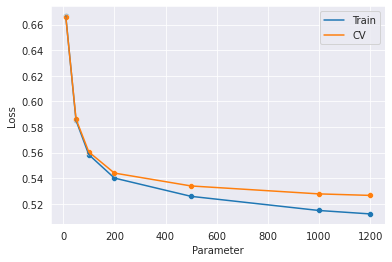

In [ ]:
param =  [10,50,100,200,500,1000,1200]
train_error_list = [] 
val_error_list = []

for i in param:
    lgb = LGBMRegressor(  n_estimators = i , n_jobs=-1 )
    lgb.fit(x_train_s,y_train_s)
    
    train_pred = lgb.predict(x_train)
    val_pred = lgb.predict(x_val)
    
    train_error = np.sqrt(mean_squared_error(y_train,train_pred))
    val_error = np.sqrt(mean_squared_error(y_val,val_pred))
    
    train_error_list.append(train_error)
    val_error_list.append(val_error)
    
    print(f"validation Loss for parameter {i}=",val_error)

sns.set_style("darkgrid")
sns.lineplot(x=param,y=train_error_list,label="Train")
sns.scatterplot(x=param,y=train_error_list)
sns.lineplot(x=param,y=val_error_list,label="CV")
sns.scatterplot(x=param,y=val_error_list)
plt.xlabel("Parameter")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
start_time = time.time()
lgb = LGBMRegressor(  n_estimators = 1200 , n_jobs=-1 )
lgb.fit(x_train,y_train)
print("Time Taken= ",round(time.time()-start_time,2),"s")

Time Taken=  447.32


In [ ]:
train_pred_lgb = lgb.predict(x_train)
val_pred_lgb = lgb.predict(x_val)

### Performace

In [ ]:
# TRAIN ERROR
np.sqrt(mean_squared_error(y_train ,train_pred_lgb))

0.47835884435349885

In [ ]:
# VALIDATION ERROR
np.sqrt(mean_squared_error(y_val , val_pred_lgb))

0.5007886241480397

In [ ]:
# TEST PREDICTIONS
lgb_predict = pd.DataFrame()
lgb_predict["test id"] = df_test.index
lgb_predict["price"] = log_to_actual(lgb.predict(x_test))
lgb_predict.to_csv("lgb_predict.csv")
lgb_predict

,test id,price
0,0,10.083432
1,1,9.014563
2,2,43.318544
3,3,13.697506
4,4,7.493793
...,...,...
3460720,3460720,14.420654
3460721,3460721,22.724261
3460722,3460722,15.555303
3460723,3460723,20.546963


### Kaggle Score  for Test_data

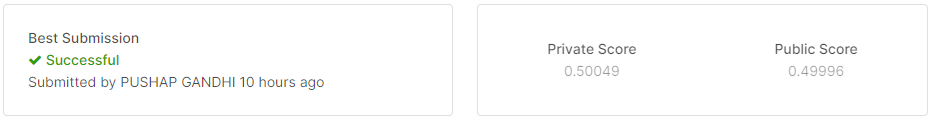

In [8]:
Image("screenshot/lgb_w2v.png")

# 2. Feature Engineering 
---------------------------------
##    <font color='blue'> **Categorical Data : One Hot Encoding** </font> 
##   <font color='blue'>**Text Data : Tfidf** </font>

##  <font color='green'> Categorical Data  </font>

### 1.  item_condition_id

In [11]:
train_vec_item_con = pd.get_dummies(df_train.item_condition_id).values
val_vec_item_con = pd.get_dummies(df_val.item_condition_id).values

In [12]:
print(train_vec_item_con.shape)
print(val_vec_item_con.shape)

(1334281, 5)
(148254, 5)


In [31]:
test_vec_item_con = pd.get_dummies(df_test.item_condition_id).values
print(test_vec_item_con.shape)

(3460725, 5)


### 2.  shipping

In [13]:
train_vec_shipping = pd.get_dummies(df_train.shipping).values
val_vec_shipping = pd.get_dummies(df_val.shipping).values

In [14]:
print(train_vec_shipping.shape)
print(val_vec_shipping.shape)

(1334281, 2)
(148254, 2)


In [32]:
test_vec_shipping = pd.get_dummies(df_test.shipping).values
print(test_vec_shipping.shape)

(3460725, 2)


### 3.  brand_name

In [15]:
label_brand = OneHotEncoder(handle_unknown="ignore")
label_brand.fit(df_train.brand_name_processed.values.reshape(-1,1))

train_vec_brand =label_brand.transform(df_train.brand_name_processed.values.reshape(-1,1))
val_vec_brand = label_brand.transform(df_val.brand_name_processed.values.reshape(-1,1))

print(train_vec_brand.shape)
print(val_vec_brand.shape)

(1334281, 4702)
(148254, 4702)


In [33]:
test_vec_brand = label_brand.transform(df_test.brand_name_processed.values.reshape(-1,1))
print(test_vec_brand.shape)

(3460725, 4702)


### 4.  Tier_1

In [16]:
label_t1 = OneHotEncoder(handle_unknown='ignore')
label_t1.fit(df_train.Tier_1.values.reshape(-1,1))

train_vec_t1 = label_t1.transform(df_train.Tier_1.values.reshape(-1,1))
val_vec_t1 =   label_t1.transform(df_val.Tier_1.values.reshape(-1,1))


print(train_vec_t1.shape)
print(val_vec_t1.shape)


(1334281, 11)
(148254, 11)


In [34]:
test_vec_t1 =   label_t1.transform(df_test.Tier_1.values.reshape(-1,1))
print(test_vec_t1.shape)

(3460725, 11)


### 5.  Tier_2

In [17]:
label_t2 = OneHotEncoder(handle_unknown='ignore')
label_t2.fit(df_train.Tier_2.values.reshape(-1,1))

train_vec_t2 =label_t2.transform(df_train.Tier_2.values.reshape(-1,1))
val_vec_t2 = label_t2.transform(df_val.Tier_2.values.reshape(-1,1))

print(train_vec_t2.shape)
print(val_vec_t2.shape)


(1334281, 111)
(148254, 111)


In [35]:
test_vec_t2 = label_t2.transform(df_test.Tier_2.values.reshape(-1,1))
test_vec_t2.shape

(3460725, 111)

### 6. Tier_3

In [18]:
label_t3 = OneHotEncoder(handle_unknown='ignore')
label_t3.fit(df_train.Tier_3.values.reshape(-1,1))

train_vec_t3 =label_t3.transform(df_train.Tier_3.values.reshape(-1,1))
val_vec_t3 = label_t3.transform(df_val.Tier_3.values.reshape(-1,1))
#
print(train_vec_t3.shape)
print(train_vec_t3.shape)
#

(1334281, 863)
(1334281, 863)


In [36]:
test_vec_t3 = label_t3.transform(df_test.Tier_3.values.reshape(-1,1))
test_vec_t3.shape

(3460725, 863)

##  <font color='green'> Text Data  </font>

## Tfidf
### 7. name_processed

In [19]:
tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=50000)
tfidf.fit(df_train.name_processed)

train_vec_name = tfidf.transform(df_train.name_processed)
val_vec_name = tfidf.transform(df_val.name_processed)


print(train_vec_name.shape)
print(val_vec_name.shape)


(1334281, 50000)
(148254, 50000)


In [37]:
test_vec_name = tfidf.transform(df_test.name_processed)
print(test_vec_name.shape)


(3460725, 50000)


### 8. processed_item_description

In [38]:
tfidf_desc = TfidfVectorizer(max_features=50000,ngram_range=(1, 2))
tfidf_desc.fit(df_train.processed_item_description)

train_vec_desc = tfidf_desc.transform(df_train.processed_item_description  )
val_vec_desc   = tfidf_desc.transform(df_val.processed_item_description)


print(train_vec_desc.shape)
print(val_vec_desc.shape)


(1334281, 50000)
(148254, 50000)


In [39]:
test_vec_desc   = tfidf_desc.transform(df_test.processed_item_description)
print(test_vec_desc.shape)

(3460725, 50000)


### 9. is_missing

In [21]:
df_train["is_missing"]  =  (df_train.brand_name_processed=="missing") | (df_train.name_processed =="missing")| (df_train.processed_item_description=="missing")
df_train["is_missing"]  = df_train["is_missing"].astype(int)

In [22]:
df_val["is_missing"]  =  (df_val.brand_name_processed=="missing") | (df_val.name_processed =="missing")| (df_val.processed_item_description=="missing")
df_val["is_missing"]  = df_val["is_missing"].astype(int)

In [40]:
df_test["is_missing"]  =  (df_test.brand_name_processed=="missing") | (df_test.name_processed =="missing")| (df_test.processed_item_description=="missing")
df_test["is_missing"]  = df_test["is_missing"].astype(int)

## Concatenating

In [41]:
x_train = hstack((train_vec_item_con,train_vec_shipping,
                  train_vec_name,train_vec_brand,train_vec_t1,
                   train_vec_t2,
                    train_vec_t3,
                  df_train.is_missing.values.reshape(-1,1)
                   ,train_vec_desc))


x_val = hstack((val_vec_item_con,val_vec_shipping
                ,val_vec_name ,val_vec_brand ,val_vec_t1 ,\
                  val_vec_t2 ,val_vec_t3 ,
                df_val.is_missing.values.reshape(-1,1)
                ,val_vec_desc))

x_test = hstack((test_vec_item_con,test_vec_shipping
                ,test_vec_name ,test_vec_brand ,test_vec_t1 ,\
                  test_vec_t2 ,test_vec_t3 ,
                df_test.is_missing.values.reshape(-1,1)
                ,test_vec_desc))

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1334281, 105695)
(148254, 105695)
(3460725, 105695)


## Sampling for hyperparameter tuning

In [ ]:
def sample(x_train,y_train):
    np.random.seed(5)
    index = np.random.random_integers(0,x_train.shape[0]-1,size=int(0.5*x_train.shape[0]))
    
    x_train_s = x_train.tocsr()[index]
    y_train_s = y_train.values[index]
    
    return x_train_s,y_train_s

x_train_s,y_train_s = sample(x_train,y_train)

In [ ]:
x_train_s.shape

(667140, 105695)

In [ ]:
y_train_s.shape

(667140,)

## C. Models

### Linear Regression

In [46]:
lr = LinearRegression(normalize=True)
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [47]:
# TRAIN PREDICTION
train_pred_lr = lr.predict(x_train)
# VALIDATION PREDICTION
val_pred_lr = lr.predict(x_val)

In [48]:
# TRAIN ERROR
train_error = np.sqrt(mean_squared_error(y_train,train_pred_lr))
print("Train Error",train_error)
# TEST ERROR
val_error = np.sqrt(mean_squared_error(y_val,val_pred_lr))
print("Validation Error",val_error)

Train Error 0.4240856531220295
Validation Error 0.462005027590113


In [50]:
# TEST PREDICTION
lr_predict = pd.DataFrame()
lr_predict["test id"] = df_test.index
lr_predict["price"] = log_to_actual(lr.predict(x_test))
lr_predict.to_csv("/content/drive/MyDrive/Colab Notebooks/cs1/linear_tfidf_predict.csv")
lr_predict

,test id,price
0,0,9.421793
1,1,6.430594
2,2,43.903771
3,3,17.423751
4,4,7.696457
...,...,...
3460720,3460720,10.841800
3460721,3460721,45.800019
3460722,3460722,18.338031
3460723,3460723,22.851977


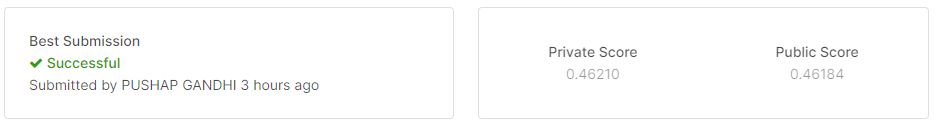

In [12]:
Image("screenshot/linear_tfidf.png") 

### Ridge 

validation Loss for parameter 1e-05= 0.49755259177159245
validation Loss for parameter 0.0001= 0.4974438413191783
validation Loss for parameter 0.001= 0.4975745774625851
validation Loss for parameter 0.01= 0.4968724109397735
validation Loss for parameter 0.1= 0.4913099674852727
validation Loss for parameter 1= 0.4733456524851951
validation Loss for parameter 10= 0.4667471732193462
validation Loss for parameter 100= 0.49781922411659946
validation Loss for parameter 1000= 0.5575574953163212
validation Loss for parameter 10000= 0.6316940251561611
validation Loss for parameter 100000= 0.6878215711865616


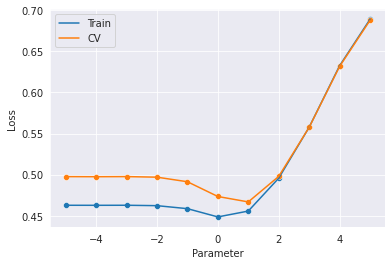

In [ ]:
param =  [10**x for x in range(-5,6)]
train_error_list = [] 
val_error_list = []
for i in param:
    l2 = Ridge(alpha=i)
    l2.fit(x_train_s,y_train_s)
    
    train_pred = l2.predict(x_train)
    val_pred = l2.predict(x_val)
    
    train_error = np.sqrt(mean_squared_error(y_train,train_pred))
    val_error = np.sqrt(mean_squared_error(y_val,val_pred))
    
    train_error_list.append(train_error)
    val_error_list.append(val_error)
    
    print(f"validation Loss for parameter {i}=",val_error)

log_param = np.log10(np.array(param))
sns.set_style("darkgrid")
sns.lineplot(x=log_param,y=train_error_list,label="Train")
sns.scatterplot(x=log_param,y=train_error_list)
sns.lineplot(x=log_param,y=val_error_list,label="CV")
sns.scatterplot(x=log_param,y=val_error_list)
plt.xlabel("Parameter")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [51]:
# best_alpha = 10

l2_best = Ridge(alpha=10)
l2_best.fit(x_train,y_train)


Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [52]:
# TRAIN PREDICTION
train_pred = l2_best.predict(x_train)
# VALIDATION PREDICTION
val_pred = l2_best.predict(x_val)

In [53]:
# TRAIN ERROR
train_error = np.sqrt(mean_squared_error(y_train,train_pred))
print("Train Error = ",train_error)
# VALIDATION ERROR
val_error = np.sqrt(mean_squared_error(y_val,val_pred))
print("Validation Error = ",val_error)

Train Error =  0.4414230414196563
Validation Error =  0.45812050428950885


In [54]:
# TEST PREDICTIONS
ridge_predict = pd.DataFrame()
ridge_predict["test id"] = df_test.index
ridge_predict["price"] = log_to_actual(l2_best.predict(x_test))
ridge_predict.to_csv("/content/drive/MyDrive/Colab Notebooks/cs1/ridge_tfidf_predict.csv")
ridge_predict

,test id,price
0,0,9.115427
1,1,9.131144
2,2,42.475776
3,3,16.718650
4,4,7.526651
...,...,...
3460720,3460720,9.641794
3460721,3460721,32.770082
3460722,3460722,17.666883
3460723,3460723,21.367717


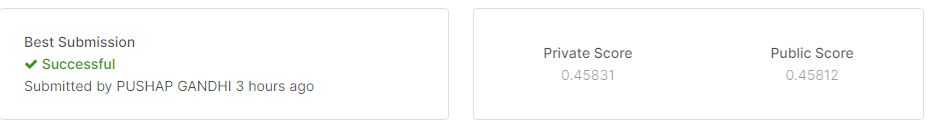

In [14]:
Image("screenshot/ridge_tfidf.png") 

##  Model Comparison

In [18]:
res = pd.DataFrame()
res["Model"] = ["Benchmark","Lasso","Ridge","Decision Tree","Random Forest","Light GBM","linear Regression","Ridge"]
res["Feature Type"] = ["-","Label Endoing+Word2Vec","Label Endoing+Word2Vec","Label Endoing+Word2Vec","Label Endoing+Word2Vec","Label Endoing+Word2Vec","One hot endoding + Tfidf", "One hot endoding + Tfidf"]
res["Best Param"] = ["-",1e-5,10,10,500,1200,"-",10]
res["Train Error"] = [0.7267,0.6043,0.6043,0.6273,"-",0.4784,0.4241,4414]
res["Validation Error"] = [0.7255,0.6037,0.6037,0.6353,"-",0.5008,0.4620,0.4581]
res["Test Error"] = [0.72753,0.60518,0.60518,0.6370,"-",0.50050,0.46210,0.45831]
res

,Model,Feature Type,Best Param,Train Error,Validation Error,Test Error
0,Benchmark,-,-,0.7267,0.7255,0.72753
1,Lasso,Label Endoing+Word2Vec,1e-05,0.6043,0.6037,0.60518
2,Ridge,Label Endoing+Word2Vec,10,0.6043,0.6037,0.60518
3,Decision Tree,Label Endoing+Word2Vec,10,0.6273,0.6353,0.637
4,Random Forest,Label Endoing+Word2Vec,500,-,-,-
5,Light GBM,Label Endoing+Word2Vec,1200,0.4784,0.5008,0.5005
6,linear Regression,One hot endoding + Tfidf,-,0.4241,0.462,0.4621
7,Ridge,One hot endoding + Tfidf,10,4414,0.4581,0.45831


#### Observation:
* The best model for first cut approach is Ridge Model wiht Tfidf Features 
* For label encoded and word2vec features complex models like Light GBM performs better than simple linear models like lasso,ride.
* But for Tdidf features the features become comparetuvely higher therfore liear models give decent values of performance metric.
